## Analysis of trajectories from flies in fly bowl during CsChrimson stimulation
###Project: Flp-out based CsChrimson activation of putative CX-output neurons in walking flies

#####This notebook contains adjustments to the one from 22.06.2015 based on Chuntao's suggestions.

In [18]:
from scipy.io import loadmat
import csv
import matplotlib.colors as colors
import numpy as np
from scipy import sparse as sps

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
import os

import seaborn as sns

%matplotlib inline

# Note: Additional functions are defined at the end of this script. 
# Corresponding cells need to be evaluated before running the ananlysis for the first time

In [21]:
rootDir = '/Volumes/public/Ming2Chuntao/2015-06-09'
analysisDir = '/Volumes/jayaramanlab/Hannah/FlyBowlAnalysis'

# os.system('ls ' + baseDir  +  '> test.txt') 
# One option.. saves list in directory with scripts.

with open(rootDir + '/experimentList.txt') as expList_handle:
    expList = expList_handle.read().splitlines()

In [22]:
len(expList)

30

In [98]:
folder = expList[5]
# Example:
#   folder = 'SS02191_UAS-FRT-CsChrimson-mVeuns_attP18_hsFLP-PEST_attP3_HS0-3hALH120min_120min_flyBowlMing_protocolVer3_Chuntao_CsChrimson_1intensities_20150609T111151'
#   genotype = 'SS02191_UAS-FRT-CsChrimson-mVeuns_attP18_hsFLP-PEST_attP3_HS0-3hALH120min_120min'
#   experiment = 'flyBowlMing_protocolVer3_Chuntao_CsChrimson_1intensities'

fileNameParts = folder.split('_')

genotype = '_'.join(fileNameParts[0:fileNameParts.index('flyBowlMing')])
experiment = '_'.join(fileNameParts[fileNameParts.index('flyBowlMing'):-1])

In [99]:
print(genotype)
print(experiment)

GMR_16D01_AE_01_UAS-FRT-CsChrimson-mVeuns_attP18_hsFLP-PEST_attP3_HS0-3hALH120min_120min
flyBowlMing_protocolVer3_Chuntao_CsChrimson_1intensity_5sOn


In [100]:
fileName = 'ctrax_results'

fps = 30 # Video sampling rate

plotSaveDir = analysisDir + '/' + genotype + '/' + experiment

try:
    os.mkdir(analysisDir + '/' + genotype )
except OSError:
    print('Genotype folder already exists')
    
try:
    os.mkdir(plotSaveDir)
except OSError:
    print('Experiment folder already exists')

Genotype folder already exists


### Import and rearrange data

#### Extract protocol parameter

In [101]:
protocol = loadmat(rootDir + '/' + folder + '/protocol.mat') #load protocol parameter
protocol = protocol['protocol'] #extract values from dict
protocol

array([[ ([[1]], [[15]], [[5000]], [[5000]], [[1]], [[15000]], [[20]], [[10]], [[221000]])]], 
      dtype=[('stepNum', 'O'), ('intensity', 'O'), ('pulseWidthSP', 'O'), ('pulsePeriodSP', 'O'), ('pulseNum', 'O'), ('offTime', 'O'), ('delayTime', 'O'), ('iteration', 'O'), ('duration', 'O')])

In [102]:
intensity = protocol['intensity'].squeeze().astype('int')
pulseWidth = protocol['pulseWidthSP'].squeeze().astype('int')
pulsePeriod = protocol['pulsePeriodSP'].squeeze().astype('int')
stimTms = pulseWidth
pauseTms = protocol['offTime'].squeeze().astype('int')
numRepeat = protocol['iteration'].squeeze().astype('int')
delayStart = protocol['delayTime'].squeeze().astype('int')

stimCycle = (stimTms+pauseTms)/1000

# total length of protocol
experimentT = (delayStart + numRepeat*stimCycle*fps)
experimentT

6020

In [103]:
skipFrame = 3 #downsample from 30Hz --> 10Hz

#Build indicator vector for red light stimulation
stimBlock = np.hstack((np.ones((stimTms/1000)*fps),np.zeros((pauseTms/1000) * fps)))
stimCode = np.tile(stimBlock,numRepeat)

trialBlock = np.ones(((stimTms+pauseTms)/1000)*fps)
trialCode = np.repeat(range(1,numRepeat+1),((stimTms+pauseTms)/1000)*fps)

In [104]:
trialBegin = [(k*(stimTms+pauseTms)/1000.0)*fps/skipFrame for k in range(numRepeat)]
trialBlockPts = ((stimTms+pauseTms)/1000.0)*fps/skipFrame
trialBlockT = np.linspace(0,(stimTms+pauseTms)/1000.0,trialBlockPts)

#### Extract relevant tracking parameter

In [105]:
keyList = ['timestamps','x_pos','y_pos','ntargets','identity','angle'] #data columns to be extracted from ctrax file

#load matlab data and convert
indat = loadmat(rootDir + '/' + folder + '/' + fileName + '.mat')

dat = [indat[k] for k in keyList]
    
# Reorganise fly position arrays into lists (sorted by frame)
numFrames = len(dat[0])
xPos = []
yPos = []
angle = []
flyID = []

pointer = 0
for t in range(numFrames):
    numFlies = dat[3][t].astype('int')[0]

    xPos.append(dat[1][pointer:pointer+numFlies])
    yPos.append(dat[2][pointer:pointer+numFlies])
    angle.append(dat[5][pointer:pointer+numFlies])
    flyID.append(dat[4][pointer:pointer+numFlies])

    pointer += numFlies
    
xPos = np.array(xPos)
yPos = np.array(yPos)
angle = np.array(angle)
flyID = np.array(flyID)
maxFlyID = max(dat[4])

#### Visualise tracking performance

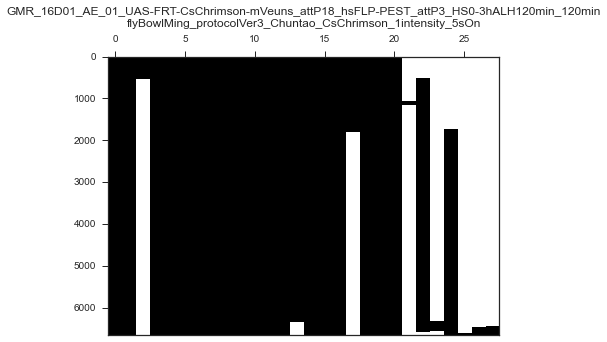

In [106]:
# Reorganise fly track fragments into matrix (frame x fly id )
flyIDperFrame = np.zeros((numFrames,maxFlyID+1))
for frame in range(numFrames):
    for idx in np.array(flyID[frame]).squeeze().astype('int'):
        flyIDperFrame[frame][idx] = 1

#visualise resluting matrix
fragmentFig = plotSparseMatrix((7,5),0.003,flyIDperFrame, genotype + '\n' + experiment + '\n')

fragmentFig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_traceFragments.pdf', format = 'pdf')

### Plot tracking data
#### Visualise response of all flies to first light pulse

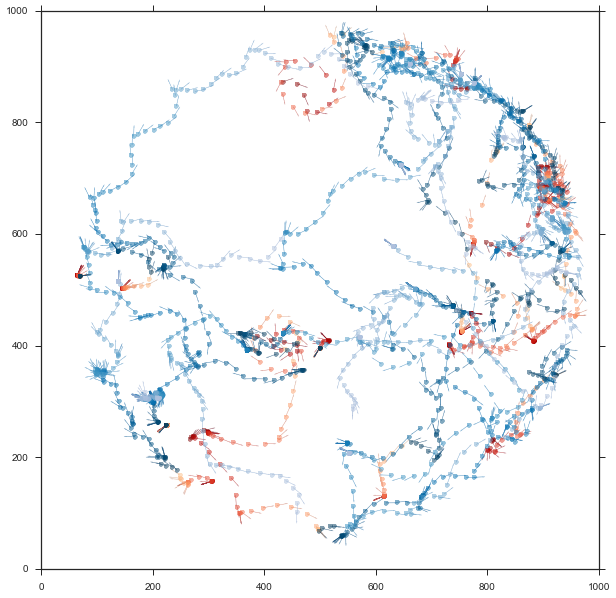

In [107]:
fig = plt.figure(figsize=(10,10))
sbplt = fig.add_subplot(111)

firstStim = range(delayStart * fps,(delayStart + stimTms/1000) * fps,6)
plotPosInRange(sbplt,firstStim,xPos,yPos,angle,'OrRd')

firstPause = range((delayStart + stimTms/1000)*fps,(delayStart + ((stimTms+pauseTms)/1000)) * fps,5)
plotPosInRange(sbplt,firstPause,xPos,yPos,angle,'PuBu')

fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_firstTrialTraces.pdf', format = 'pdf')

#### Plot per-fly walking statistics

In [108]:
#compute translational and rotational velocity over entire experiment
frameRange = range((delayStart)*fps,(delayStart + numRepeat*((stimTms+pauseTms)/1000)) * fps,skipFrame)
activeFragments = np.array(np.nonzero(sum(flyIDperFrame[frameRange]))).squeeze()

transV = np.zeros((len(frameRange),len(activeFragments)))
rotV = np.zeros((len(frameRange),len(activeFragments)))

for k, fly in enumerate(activeFragments):
    
    currTransV = np.zeros((len(frameRange),1))
    currRotV = np.zeros((len(frameRange),1))
    
    for ind,frame in enumerate(frameRange):
        if((not np.any(flyID[frame] == fly)) or (not np.any(flyID[frame-skipFrame] == fly))):
            continue;
            
        currTransV[ind] = np.hypot(xPos[frame][flyID[frame] == fly] - xPos[frame-skipFrame][flyID[frame-skipFrame] == fly],
                                  yPos[frame][flyID[frame] == fly] - yPos[frame-skipFrame][flyID[frame-skipFrame] == fly])
        
        currRotV[ind] = angle[frame][flyID[frame] == fly] - angle[frame-skipFrame][flyID[frame-skipFrame] == fly]
        if(currRotV[ind]>np.pi): currRotV[ind] = currRotV[ind]-2*np.pi
        if(currRotV[ind]<-np.pi): currRotV[ind] = currRotV[ind]+2*np.pi
    
    transV[:,k] = currTransV.squeeze()
    rotV[:,k] = currRotV.squeeze()

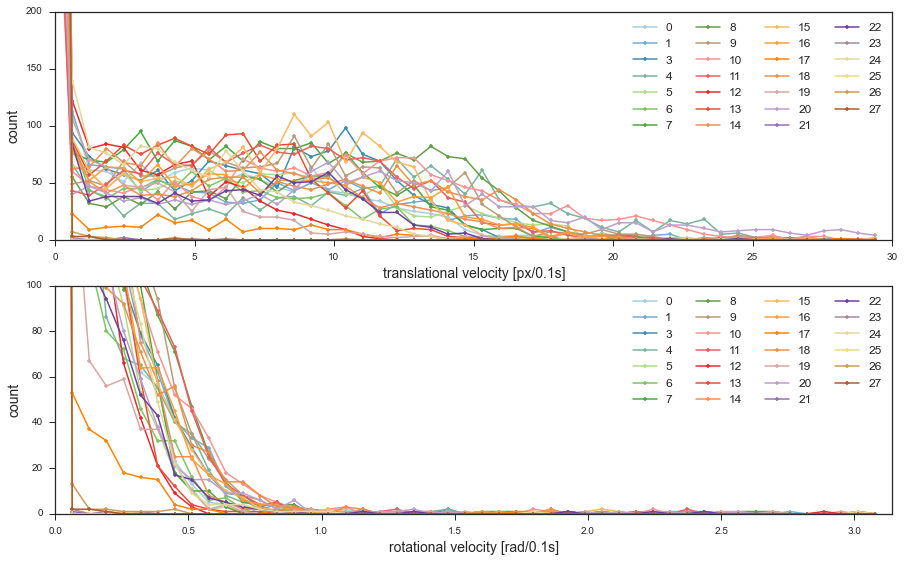

In [109]:
# Plot results
Vfig = plt.figure(figsize=(15,9))
tVplt = Vfig.add_subplot(211)
rVplt = Vfig.add_subplot(212)

cNorm  = colors.Normalize(vmin=min(activeFragments), vmax=max(activeFragments))
FlyMap = plt.cm.ScalarMappable(norm=cNorm,cmap='Paired')

for k, fly in enumerate(activeFragments):
    flyColor = FlyMap.to_rgba(fly)
        
    histVal, binEdges = np.histogram(transV[:,k],bins=np.linspace(0,30,50))
    binLoc = binEdges[0:-1]#-0.5*np.mean(np.diff(binEdges))
    tVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)
    
    histVal, binEdges = np.histogram(abs(rotV[:,k]),bins=np.linspace(0,np.pi,50))
    binLoc = binEdges[0:-1]#-0.5*np.mean(np.diff(binEdges))
    rVplt.plot(binLoc,histVal,color=flyColor,marker='.',linewidth=1.5)


tVplt.set_ylim((0,200))
tVplt.set_xlim((0,30))
tVplt.set_xlabel('translational velocity [px/0.1s]',fontsize = 14)
tVplt.set_ylabel('count',fontsize = 14)
tVplt.legend(activeFragments,ncol=4,fontsize = 12)
tVplt.yaxis.set_ticks_position('left')
tVplt.xaxis.set_ticks_position('bottom')

rVplt.set_ylim((0,100))
rVplt.set_xlim((0,np.pi))
rVplt.set_xlabel('rotational velocity [rad/0.1s]',fontsize = 14)
rVplt.set_ylabel('count',fontsize = 14)
rVplt.legend(activeFragments,ncol=4,fontsize = 12)
rVplt.yaxis.set_ticks_position('left')
rVplt.xaxis.set_ticks_position('bottom')



Vfig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_veloDistribution.pdf', format = 'pdf')

#### Trigger on light ON

In [110]:
windowPreMS = 1000
windowPostMS = 3000
stimDurationS = stimTms/1000
#Note: to be able to look at pre-stimulus window, the first trial is not regarded
trialBegin = [((k+1)*(stimTms+pauseTms)/1000.0)*fps/skipFrame for k in range(numRepeat-1)]
trialWindowBlockPts = ((stimTms+windowPreMS+windowPostMS)/1000.0)*fps/skipFrame
trialWindowBlockT = np.linspace(-windowPreMS/1000.0,(stimTms+windowPostMS)/1000.0,trialWindowBlockPts)
plotBegin = [trialBegin[i]-windowPreMS/1000.0*fps/skipFrame for i in range(len(trialBegin))]

problem with trace fragment of fly27


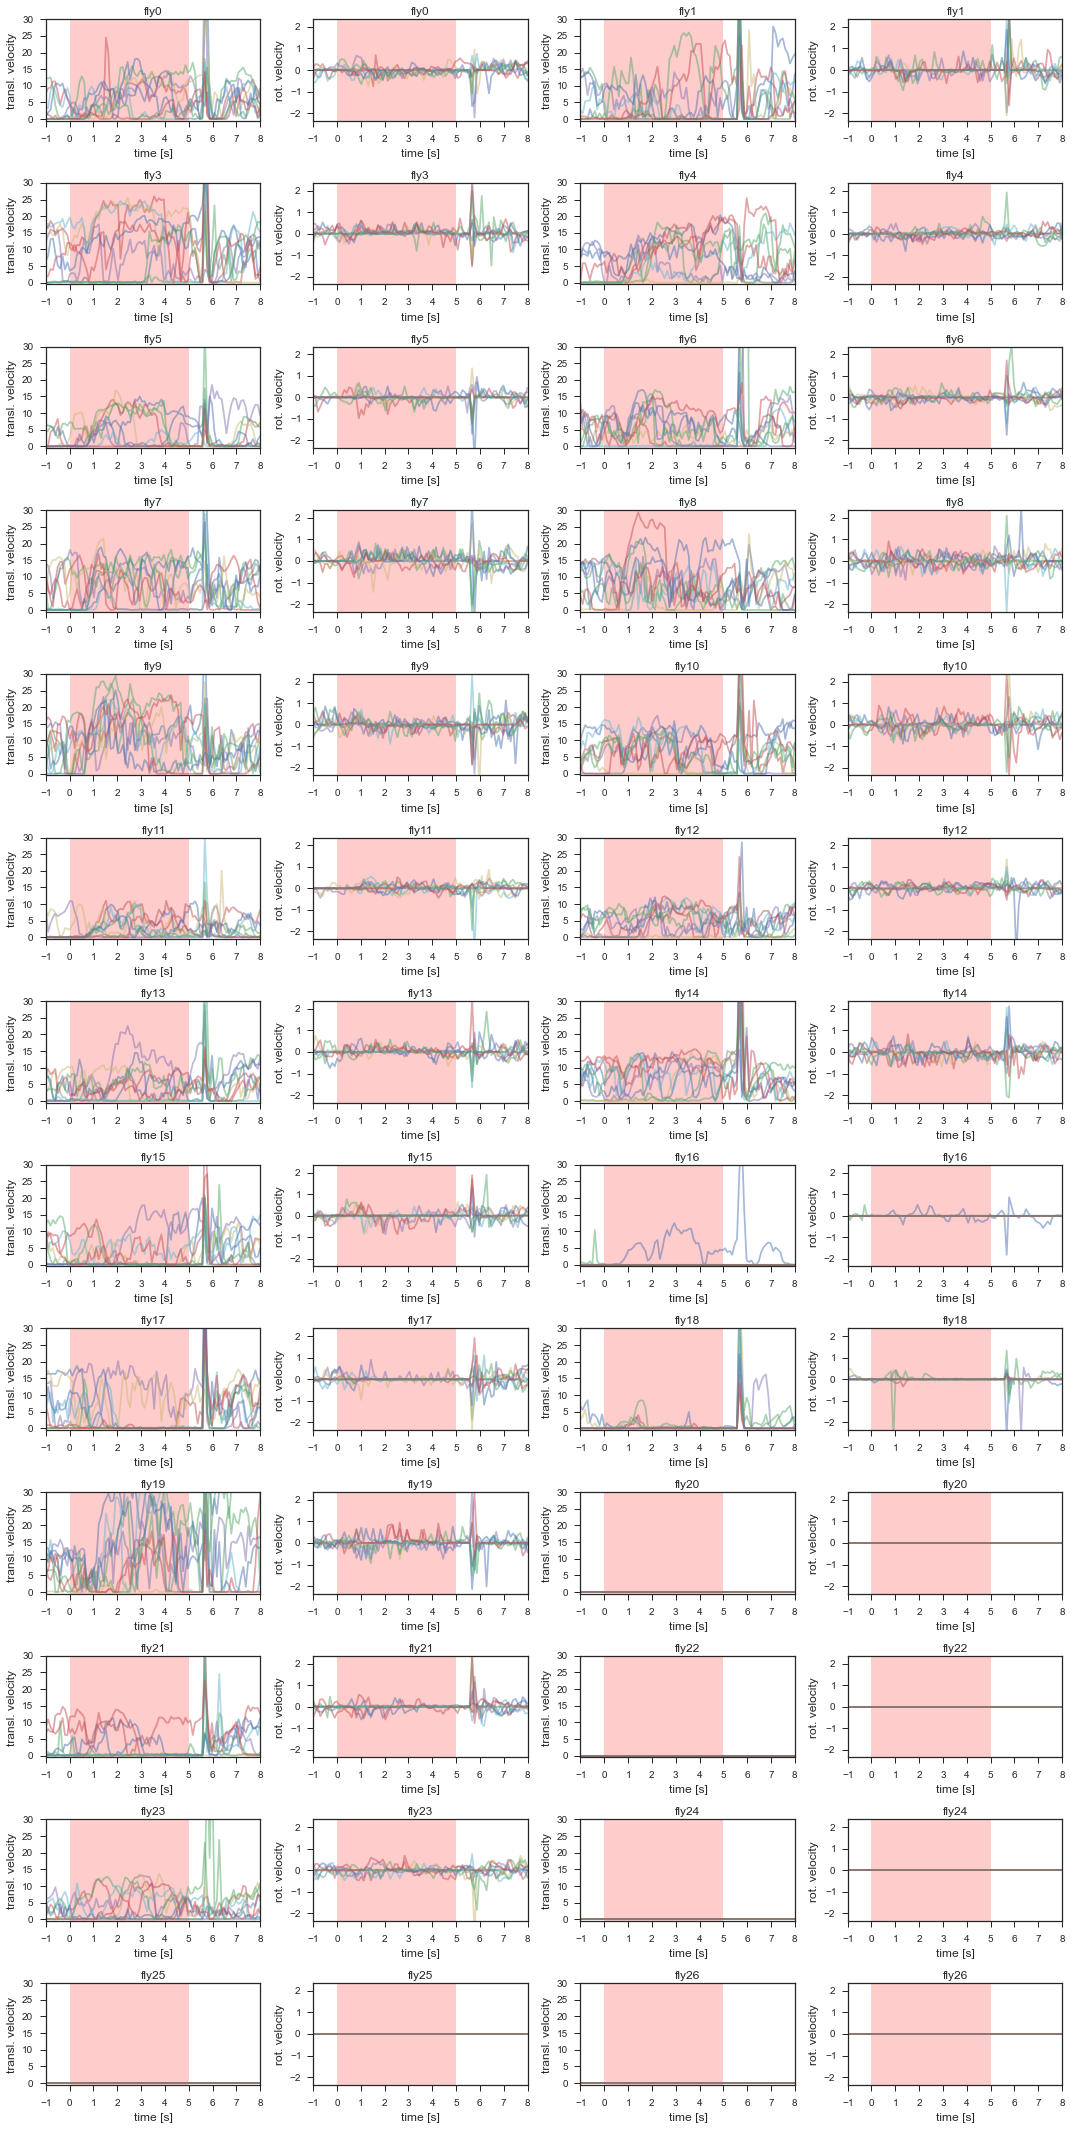

In [111]:
fig=plt.figure(figsize=(15,1.1*len(activeFragments)))

sbpltCounter = 1
for fly in activeFragments:
    
    try:
        vTplt = fig.add_subplot(len(activeFragments)/2,4,sbpltCounter)
        veloPerTrial(transV,trialWindowBlockT,plotBegin,fly,'transl. velocity',vTplt)
        vTplt.add_patch(
        patches.Rectangle((0,-1), stimDurationS, 50,alpha = 0.2, facecolor = 'red', edgecolor = 'none')
        )
        vTplt.set_ylim((-0.5,30))
    
        vRplt = fig.add_subplot(len(activeFragments)/2,4,sbpltCounter+1)
        veloPerTrial(rotV,trialWindowBlockT,plotBegin,fly,'rot. velocity',vRplt)
        vRplt.add_patch(
            patches.Rectangle((0,-5), stimDurationS, 10,alpha = 0.2, facecolor = 'red', edgecolor = 'none')
        )
        vRplt.set_ylim((-0.75*np.pi,0.75*np.pi))
        
        sbpltCounter +=2
    except:
        print('problem with trace fragment of fly' + str(fly))
        
plt.tight_layout()
fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_summary.pdf', format = 'pdf')

####Plot distribution and trajectories of responding flies

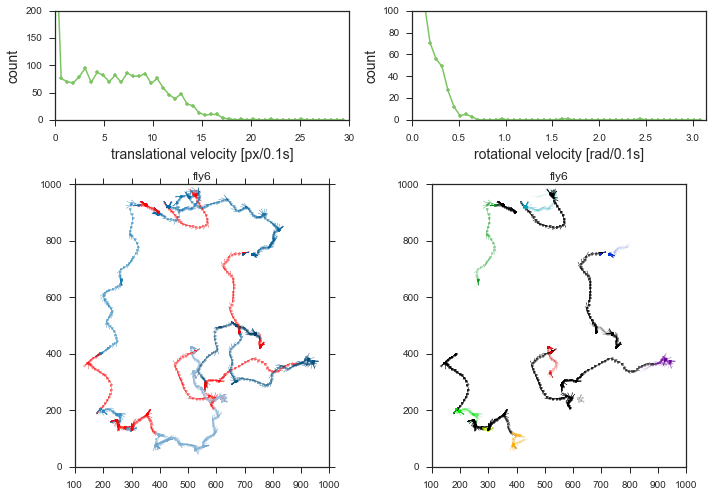

In [112]:
fly = 6

fullExperiment = range(delayStart*fps,(delayStart + numRepeat*((stimTms+pauseTms)/1000)) * fps,skipFrame)
stimCodeFrames = stimCode[range(0,len(stimCode),skipFrame)]
trialCodeFrames = trialCode[range(0,len(trialCode),skipFrame)]

fig=plt.figure(figsize=(10,7))

tVplt = fig.add_subplot(3,2,1)
plotVeloHistogram(transV,fly,np.linspace(0,30,50),tVplt,'translational velocity [px/0.1s]',FlyMap.to_rgba(fly))
tVplt.set_ylim((0,200))
tVplt.set_xlim((0,30))


rVplt = fig.add_subplot(3,2,2)
plotVeloHistogram(rotV,fly,np.linspace(0,np.pi,50),rVplt,'rotational velocity [px/0.1s]',FlyMap.to_rgba(fly))
rVplt.set_ylim((0,100))
rVplt.set_xlim((0,np.pi))
rVplt.set_xlabel('rotational velocity [rad/0.1s]',fontsize = 14)


posPlt = fig.add_subplot(3,2,(3,5))
posPlt.set_title('fly' + str(fly))
plotPosInRange_singleFly_colorStim(posPlt,fullExperiment,stimCodeFrames,xPos,yPos,angle,fly,'PuBu')


posPlt = fig.add_subplot(3,2,(4,6))
posPlt.set_title('fly' + str(fly))
plotPosInRange_singleFly_colorTrial(posPlt,fullExperiment,stimCodeFrames,trialCodeFrames,
                                    len(trialCodeFrames)/numRepeat,xPos,yPos,angle,fly,'nipy_spectral')

plt.tight_layout()
fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_fly' + str(fly) + '.pdf', format = 'pdf')

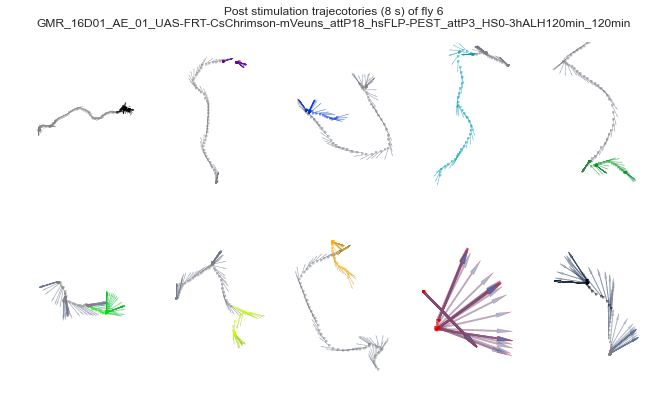

In [113]:
trialBegin_traces = [(delayStart + k*(stimTms+pauseTms)/1000)*fps for k in range(numRepeat)]
windowSize = stimTms/1000 + 3
skipFrame = 2
stimFrames = stimTms/1000 * fps
postStimFrames = windowSize*fps

currCmap = 'nipy_spectral'
fig = plt.figure(figsize=(11,6))
fig.suptitle('Post stimulation trajecotories (' + str(windowSize) + ' s) of fly ' + str(fly) + '\n' + genotype,  fontsize = 12)
plotPosInRange_singleFly_separateTrials(fig,trialBegin_traces,numRepeat,stimFrames,postStimFrames,skipFrame,xPos,yPos,angle,fly,currCmap)

fig.savefig(plotSaveDir + '/' + genotype + '_' + experiment + '_perTrialfly' + str(fly) + '.pdf', format = 'pdf')

### Function definitions
#### Defined in order of appearance in above code

In [8]:
def plotSparseMatrix(figsize,aspectRatio,matrixToPlot,titleString):
    fig = plt.figure(figsize = figsize)
    fig.set_canvas(plt.gcf().canvas)
    sns.set_style('ticks')
    ax = fig.add_subplot(111)
    ax.spy(matrixToPlot)
    ax.set_aspect(aspectRatio)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('top')
    ax.set_title(titleString)
    sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    plt.show()
    
    return fig

In [9]:
def veloPerTrial(velo,windowT,tBegin,fly,ylableString,subplotHandle):
    [subplotHandle.plot(windowT,velo[tBegin[i]:tBegin[i]+len(windowT),fly],alpha=0.5)
     for i in range(len(tBegin))];
    subplotHandle.set_ylabel(ylableString,fontsize=12)
    subplotHandle.set_xlabel('time [s]',fontsize=12)  
    subplotHandle.set_title('fly' + str(fly))
    subplotHandle.yaxis.set_ticks_position('left')
    subplotHandle.xaxis.set_ticks_position('bottom')

In [10]:
def plotPosInRange_singleFly_colorTrial(ax,frameRange,stimCode,trialCode,trialLength,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=min(trialCode), vmax=max(trialCode))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    for ind, frame in enumerate(frameRange):
        currCol=scalarMap.to_rgba(trialCode[ind])
        alphaVal = max(0,1-1.9*(ind%trialLength.astype('float'))/trialLength)      
        if(stimCode[ind]): #we are within stimulation period
            currCol = 'black'
            
        ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                marker='.',markersize = 6, linestyle='none',alpha=alphaVal ,color=currCol) 
        #alpha=(1-float(ind)/(len(frameRange)+100))
        plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                      angle[frame][flyID[frame] == fly],currCol,alphaVal,20)
        
    ax.set_aspect('equal')
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

In [11]:
def plotPosInRange_singleFly_colorStim(ax,frameRange,stimCode,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=-0.5*len(frameRange), vmax=1*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for ind, frame in enumerate(frameRange):
        currCol=scalarMap.to_rgba(len(frameRange)-ind)
        if(stimCode[ind]): #we are within stimulation period
            currCol = 'red'
            
        ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                marker='.',markersize = 6,linestyle='none',alpha=0.5, color=currCol) 
        
        plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                      angle[frame][flyID[frame] == fly],currCol,0.5,20)
        
    ax.set_aspect('equal')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})

In [12]:
def plotPosInRange_singleFly(ax,frameRange,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=-0.5*len(frameRange), vmax=1*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for frame in frameRange:
        currCol=scalarMap.to_rgba(len(frameRange)-ind)
        ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                marker='.',markersize = 6,linestyle='none',alpha=0.5,color=currCol) 
        
        plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                      angle[frame][flyID[frame] == fly],currCol,0.5,20)
        
    ax.set_aspect('equal')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    #plt.xlim([0,1000]);
    #plt.ylim([0,1000]);

In [13]:
def plotPosInRange(ax,frameRange,xPos,yPos,angle,currCmap):
    cNorm  = colors.Normalize(vmin=-0.5*len(frameRange), vmax=1*len(frameRange))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    colCounter = 0
    for frame in frameRange:
        currCol=scalarMap.to_rgba(len(frameRange)-colCounter)
        colCounter +=1
        ax.plot(xPos[frame],yPos[frame],marker='.',markersize = 10,linestyle='none',alpha=0.5,
                color=currCol) 
        
        for fly in flyID[frame]:
            plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                          angle[frame][flyID[frame] == fly],currCol,0.5,20)
        
    ax.set_aspect('equal')
    #sns.despine(right=True,offset = 0)#trim=True)
    #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})
    
    plt.xlim([0,1000]);
    plt.ylim([0,1000]);

In [14]:
def plotBodyAngle(ax,x,y,angle,markerColor,alphaVal,arrowScale):
    try:
        newArrow = patches.Arrow(x,y,np.cos(angle).squeeze()*arrowScale,np.sin(angle).squeeze()*arrowScale, width=2,
                                edgecolor = markerColor,alpha = alphaVal)
        ax.add_patch(newArrow)
    except:
        couldNotPrint = True

In [15]:
def plotVeloHistogram(velo,flyID,binVals,sbplot,xlabelString,colorCode):
    histVal, binEdges = np.histogram(velo[:,flyID],bins=binVals)
    binLoc = binEdges[0:-1]#-0.5*np.mean(np.diff(binEdges))
    sbplot.plot(binLoc,histVal,color=colorCode,marker='.',linewidth=1.5)
    
    sbplot.set_xlabel(xlabelString,fontsize = 14)
    sbplot.set_ylabel('count',fontsize = 14)
    
    sbplot.yaxis.set_ticks_position('left')
    sbplot.xaxis.set_ticks_position('bottom')

In [16]:
def plotPosInRange_singleFly_separateTrials(fig,trialBegin_traces,numTrials,stimFrames,postStimFrames,skipFrame,xPos,yPos,angle,fly,currCmap):
    cNorm  = colors.Normalize(vmin=min(trialCode), vmax=max(trialCode))
    scalarMap = plt.cm.ScalarMappable(norm=cNorm,cmap=currCmap)
    
    for trial in range(numTrials):
        ax = fig.add_subplot(np.ceil(numTrials/5.0),5,trial)
        
        #define window around stimulation pulse which should be plotted
        frameRangeStim = range(trialBegin_traces[trial],trialBegin_traces[trial]+stimFrames,skipFrame)
        frameRangePost = range(trialBegin_traces[trial]+stimFrames,trialBegin_traces[trial]+postStimFrames,skipFrame)

        for ind, frame in enumerate(frameRangeStim):
            currCol = 'grey'
            ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,color=currCol) 
            plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                          angle[frame][flyID[frame] == fly],currCol,0.5,22)
            
        for ind, frame in enumerate(frameRangePost):
            currCol=scalarMap.to_rgba(trial)
            ax.plot(xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                    marker='.',markersize = 6, linestyle='none',alpha=0.5 ,color=currCol) 
            plotBodyAngle(ax,xPos[frame][flyID[frame] == fly],yPos[frame][flyID[frame] == fly],
                          angle[frame][flyID[frame] == fly],currCol,0.5,22)

        ax.set_aspect('equal')
        plt.axis('off')
        sns.despine(right=True,left=True,bottom=True,top=True)
        #sns.axes_style({'axes.linewidth': 1, 'axes.edgecolor': '.8',})